# Assignment 4 - dimensionality reduction

This assignment focuses on two different ways for dimensionality reduction:
* feature selection
* feature extraction

This assignment has weighting $1.5$.

# Sequential feature selection (50 points)

There is a sample code in PML chapter 4 for sequential bardward selection (SBS) and its application to subsequent KNN classifier.

Implement sequential forward selection (SFS), and compare it with sequential backward selection by plotting the accuracy versus the number of features.

You can start with the sample code provided in the [slides](http://nbviewer.jupyter.org/github/1iyiwei/pyml/blob/master/code/ch04/ch04.ipynb).
You can extend the existing SBS class to handle both forward and backward selection, or implement a separate class for SFS.
Plot and compare the two accuracy versus number-of-features plots for SFS and SBS.

Use the wine dataset as follows.

In [207]:
import pandas as pd

wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_remote,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

#print('Class labels', np.unique(df_wine['Class label']))
#df_wine.head()

In [208]:
from sklearn import __version__ as skv
from distutils.version import LooseVersion as CheckVersion
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

#X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.3, random_state=0)

In [197]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Answer

Implement your sequential backward selection class here, either as a separate class or by extending the SBS class that can handle both forward and backward selection (via an input parameter to indicate the direction).

Apply your sequential forward/backward selection code to the KNN classifier with the wine data set, and plot the accuracy versus number-of-features curves for both.
Describe the similarities and differences you can find, e.g. 
* do the two methods agree on the optimal number of features?
* do the two methods have similar accuracy scores for each number of features?
* etc.

In [218]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X,y,test_size=self.test_size,
                            random_state = self.random_state)
        
        dim = X_train.shape[1]
        #print("X_train_std.shape[1]: ",X_train_std.shape[1])
        self.indices_ = tuple(range(dim))
        #print("self.indices_: ",self.indices_)
        self.subsets_ = [self.indices_]
        score = self._calc_score( X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score( X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                #print("####self.subsets_[len(self.subsets_)-1] and p are: ")
                #print(self.subsets_[len(self.subsets_)-1], p)
            ####
            #print("subsets are: ",subsets)
            ####
            best = np.argmax(scores)
            
            #print("####best subset : ",subsets[best])
            
            self.indices_ = subsets[best]
            self.subsets_.append(subsets[best])
            ####
            #print("self.subsets_ are: ",self.subsets_)
            ####
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    

In [219]:
class SFS():
    def __init__(self , estimator, k_features, scoring = accuracy_score, 
                    test_size = 0.25, random_state = 1):
        self.estimator = estimator
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self,X,y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X,y,test_size=self.test_size,
                            random_state = self.random_state)
        dim =  X_train.shape[1]
        self.indices_ = tuple(range(dim))
        #self.subsets_ = []
        #to calculate the scores when the indices size = 1:
        #scores = [self._calc_score(X_train, y_train, X_test, y_test,p) for p in combinations(self.indices_,1)]
        self.subsets_ = []
        self.scores_ = []
        
        #Initialize the self.subsets[] and self.scores[];
        scores = []
        subsets = []
        for p in combinations(self.indices_,1):
            score = self._calc_score( X_train, y_train, X_test, y_test,p)
            scores.append(score)
            subsets.append(p)
        best = np.argmax(scores)
        self.scores_ = [scores[best]]
        self.subsets_ = [subsets[best]]
        '''The below code adds a new feature into the self.subsets_ at every for loop and 
            finally gets the optimal k-feature subsets.'''
        indice = 2
        while indice <= self.k_features and indice <= dim:
            scores = []
            subsets = []
            for p in combinations(self.indices_, 1):
                if p[0] not in self.subsets_[len(self.subsets_)-1]:
                    subset = p+self.subsets_[len(self.subsets_)-1]
                    score = self._calc_score( X_train, y_train, X_test, y_test,subset)
                    scores.append(score)
                    subsets.append(subset)
                    #print("####self.subsets_[len(self.subsets_)-1] and p are: ")
                    #print(self.subsets_[len(self.subsets_)-1], p)
            indice+=1
            best = np.argmax(scores)
            #print("####best subset : ",subsets[best])
            self.scores_.append(scores[best])
            self.subsets_.append(subsets[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
    

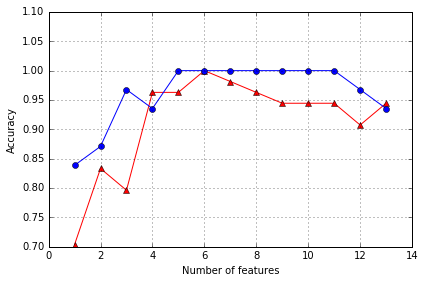

In [229]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

#SBS graph:

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
##test accuracy:
test_scores = []
for k in range(0,13):
    selectedf = list(sbs.subsets_[k])
    knn.fit(X_train_std[:,selectedf],y_train)
    test_scores.append(knn.score(X_test_std[:,selectedf],y_test))
##
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

##red line is test accuracy while blue line is training accuracy:
plt.plot(k_feat, test_scores,color = 'red',marker = '^')
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

$\large red\ line\ is\ test\ accuracy,\ blue\ one\ is\ training\ accuracy.$

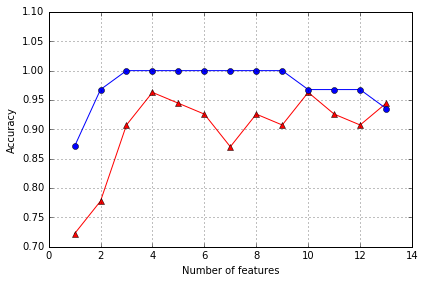

In [247]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

#SFS graph:

# selecting features
sfs = SFS(knn, k_features=13)
sfs.fit(X_train_std, y_train)
##test accuracy:
test_scores = []
for k in range(0,13):
    selectedf = list(sfs.subsets_[k])
    knn.fit(X_train_std[:,selectedf],y_train)
    test_scores.append(knn.score(X_test_std[:,selectedf],y_test))

# plotting performance of feature subsets
k_feat = [len(k) for k in sfs.subsets_]

##red line is test accuracy while blue line is training accuracy:
plt.plot(k_feat, test_scores, color = 'red', marker='^')
plt.plot(k_feat, sfs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

$\large red\ line\ is\ test\ accuracy,\ blue\ one\ is\ training\ accuracy.$

## Comparison graph between SFS and SBS:

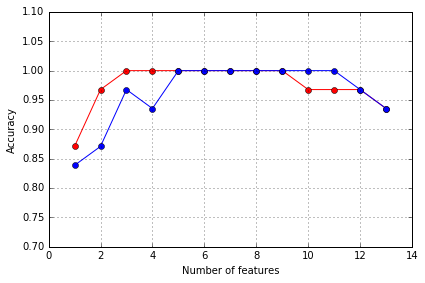

In [251]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

k_feat = [len(k) for k in sfs.subsets_]
sfs = SFS(knn, k_features=13)
sfs.fit(X_train_std, y_train)
plt.plot(k_feat, sfs.scores_,color = 'red',marker='o')

k_feat = [len(k) for k in sbs.subsets_]
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
plt.plot(k_feat, sbs.scores_, marker='o')

plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

$\large red\ line\ is\ SFS\ training\ accuracy,\ blue\ one\ is\ SBS\ training\ accuracy.$

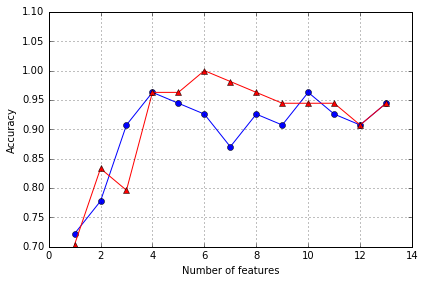

In [254]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

k_feat = [len(k) for k in sfs.subsets_]
sfs = SFS(knn, k_features=13)
sfs.fit(X_train_std, y_train)
##test accuracy:
test_scores = []
for k in range(0,13):
    selectedf = list(sfs.subsets_[k])
    knn.fit(X_train_std[:,selectedf],y_train)
    test_scores.append(knn.score(X_test_std[:,selectedf],y_test))
# plotting performance of feature subsets
k_feat = [len(k) for k in sfs.subsets_]
plt.plot(k_feat, test_scores, color = 'blue', marker='o')


k_feat = [len(k) for k in sbs.subsets_]
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
##test accuracy:
test_scores = []
for k in range(0,13):
    selectedf = list(sbs.subsets_[k])
    knn.fit(X_train_std[:,selectedf],y_train)
    test_scores.append(knn.score(X_test_std[:,selectedf],y_test))
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, test_scores,color = 'red',marker = '^')


plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

$\large red\ line\ is\ SFS\ test\ accuracy,\ blue\ one\ is\ SBS\ test\ accuracy.$

## Answer


$\large Number\ of\ features:$

The two algorithm disgrees on the number of features to optimize the 

training result. SBS uses 6 features to optimize the test accuracy while 

SFS uses 4 features to optimize it.


$\large Accuracy\ score: $

The two algorithm disgrees on the accuracy score as well.

As shown in above three graphs, we can see that they have different 

performances in optimizing both training data and test data. 


In [ ]:
%matplotlib inline

# PCA versus LDA (50 points)

We have learned two different methods for feature extraction, PCA (unsupervised) and LDA (supervised).

Under what circumstances would PCA and LDA produce very different results? 

Provide one example dataset in 2D, analyze it via PCA and LDA, and plot it with the PCA and LDA components.

You can use code from the scikit-learn library.

## Answer

As far as we know, both PCA and LDA aims to compress the number of features in order to 

improve our computational efficiency and reduce the degree of overfitting.

For PCA, it's an unsupervised algorithm and seems to work better when the class label has 

little relationship with classification result, which means that the reduced dimensions 

maximizing the covariance between different features are consistent with the reduced 

dimensions that minimizing variance among samples with same feature and maximizing variance of 

samples with different features.

For LDA, it's a supervised algorithm and the assumptions made for this algorithm are that 
    
all features are independent and data is normally distributed. Besides, we assume the classes

have identical covariance matrix.


## Logic for choosing example dataset:

    We choose the number of features to be 2 and the number of classes of the dataset is 3.

Then since PCA doesn't use the information of class label, so it may have a bad outcome 

when the projected maximized covariance dimension isn't consistent with the dimension that 

maximizes the outer classes covariance and minimizes the inner class covariance.

    If we design the class to highly correspond to one feature of above two features, the 
    
goal is achieved.


In [142]:
import pandas as pd
from io import StringIO
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

#classes highly corresponds to feature1: f1<10:class1, 10<f1<20:class2
feature1 = [i for i in 10*np.random.random([100])]+[j for j in 10*(1+np.random.random([100]))]
#Classes have nearly no relationship with feature2.
feature2 = [i for i in 50*np.random.random([200])]
#Totally three classes.
target_Y = 100*[1]+100*[2]
data_X = np.matrix([feature1,feature2]).getT()

X_train, X_test, y_train, y_test =\
    train_test_split(data_X, target_Y, test_size=0.3, random_state=None)
    
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_
data_y = np.matrix([y_train]).getT()

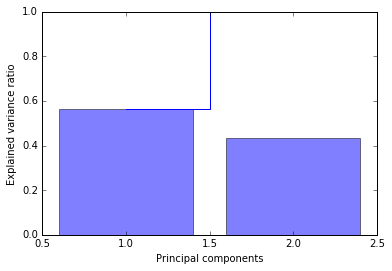

In [144]:
import matplotlib.pyplot as plt
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 3), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

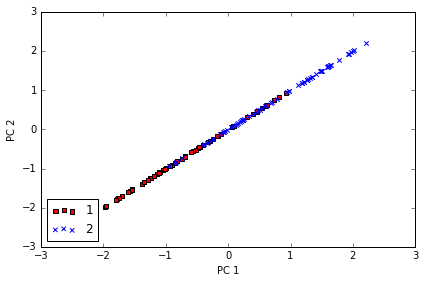

In [145]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 0],
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()


In [146]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsClassifier as KNC
knc = KNC()
knc.fit(X_train_pca, y_train)
nb = GNB()
nb.fit(X_train_pca,y_train)
rf = RFC()
rf.fit(X_train_pca, y_train)
dtc = DTC()
dtc.fit(X_train_pca,y_train)
pcn = Perceptron(penalty = None,alpha = 0.1, eta0 = 0.5)
pcn.fit(X_train_pca,y_train)
lr = LogisticRegression(C = 1000.0, random_state = 0)
lr = lr.fit(X_train_pca,np.ravel(y_train))
svm = SVC(kernel = 'rbf', C= 1.0, random_state = 0)
svm = svm.fit(X_train_pca, np.ravel(y_train))



In [147]:
X_test_lda = lda.fit_transform(X_test_std, y_test)
print("The accuracy of using PCA data reduction and SVM in this dataset is: ",accuracy_score(svm.predict(X_test_pca),y_pred))
print("The accuracy of using PCA data reduction and Logistic regression in this dataset is: ",accuracy_score(lr.predict(X_test_pca),y_pred))
print("The accuracy of using PCA data reduction and K Nearest neighbor in this dataset is: ",accuracy_score(knc.predict(X_test_pca),y_pred))
print("The accuracy of using PCA data reduction and naive bayes in this dataset is: ",accuracy_score(nb.predict(X_test_pca),y_pred))
print("The accuracy of using PCA data reduction and random forest in this dataset is: ",accuracy_score(rf.predict(X_test_pca),y_pred))
print("The accuracy of using PCA data reduction and decision tree in this dataset is: ",accuracy_score(dtc.predict(X_test_pca),y_pred))
print("The accuracy of using PCA data reduction and perceptron in this dataset is: ",accuracy_score(pcn.predict(X_test_pca),y_pred))

The accuracy of using PCA data reduction and SVM in this dataset is:  0.322222222222
The accuracy of using PCA data reduction and Logistic regression in this dataset is:  0.344444444444
The accuracy of using PCA data reduction and K Nearest neighbor in this dataset is:  0.322222222222
The accuracy of using PCA data reduction and naive bayes in this dataset is:  0.322222222222
The accuracy of using PCA data reduction and random forest in this dataset is:  0.333333333333
The accuracy of using PCA data reduction and decision tree in this dataset is:  0.355555555556
The accuracy of using PCA data reduction and perceptron in this dataset is:  0.344444444444


In [148]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 1)
X_train_lda = lda.fit_transform(X_train_std, y_train)


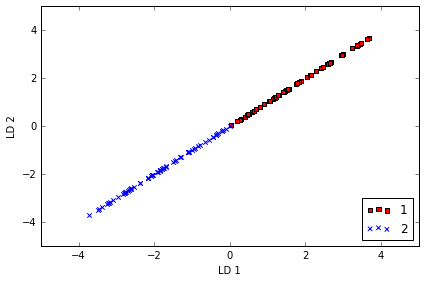

In [149]:
#X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 0] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()

In [150]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsClassifier as KNC

knc = KNC()
knc.fit(X_train_pca, y_train)
nb = GNB()
nb.fit(X_train_pca,y_train)
rf = RFC()
rf.fit(X_train_pca, y_train)
dtc = DTC()
dtc.fit(X_train_pca,y_train)
pcn = Perceptron(penalty = None,alpha = 0.1, eta0 = 0.5)
pcn.fit(X_train_pca,y_train)
lr = LogisticRegression(C = 1000.0, random_state = 0)
lr = lr.fit(X_train_pca,np.ravel(y_train))
svm = SVC(kernel = 'rbf', C= 1.0, random_state = 0)
svm = svm.fit(X_train_pca, np.ravel(y_train))




In [151]:
X_test_lda = lda.fit_transform(X_test_std, y_test)
print("The accuracy of using LDA data reduction and SVM in this dataset is: ",accuracy_score(svm.predict(X_test_pca),y_pred))
print("The accuracy of using LDA data reduction and Logistic regression in this dataset is: ",accuracy_score(lr.predict(X_test_pca),y_pred))
print("The accuracy of using LDA data reduction and K Nearest neighbor in this dataset is: ",accuracy_score(knc.predict(X_test_pca),y_pred))
print("The accuracy of using LDA data reduction and naive bayes in this dataset is: ",accuracy_score(nb.predict(X_test_pca),y_pred))
print("The accuracy of using LDA data reduction and random forest in this dataset is: ",accuracy_score(rf.predict(X_test_pca),y_pred))
print("The accuracy of using LDA data reduction and decision tree in this dataset is: ",accuracy_score(dtc.predict(X_test_pca),y_pred))
print("The accuracy of using LDA data reduction and perceptron in this dataset is: ",accuracy_score(pcn.predict(X_test_pca),y_pred))

The accuracy of using LDA data reduction and SVM in this dataset is:  0.322222222222
The accuracy of using LDA data reduction and Logistic regression in this dataset is:  0.344444444444
The accuracy of using LDA data reduction and K Nearest neighbor in this dataset is:  0.322222222222
The accuracy of using LDA data reduction and naive bayes in this dataset is:  0.322222222222
The accuracy of using LDA data reduction and random forest in this dataset is:  0.333333333333
The accuracy of using LDA data reduction and decision tree in this dataset is:  0.355555555556
The accuracy of using LDA data reduction and perceptron in this dataset is:  0.344444444444


### Observation:
After we run the principle component analysis and linear discriminant analysis on the above data, we find , as we 

expected, that the data is manipulated well by LDA but not PCA. However, if we apply the dataset to different 

classifiers, there is nearly no difference in the result. 

In [21]:
%matplotlib inline

Write code to produce your own dataset in 2D.
You are free to design relative characteristics like the number of class, the number of samples for each class, as long as your dataset could be analyzed via PCA and LDA.

Plot your data set, with different classes in different marker colors and/or shapes.

You can write your own plot code or use existing library plot code.

Apply your dataset through PCA and LDA, and plot the projected data using the same plot code.
Explain the differences you notice, and how you manage to construct your dataset to achieve such differences.

You can use the PCA and LDA code from the scikit-learn library.